In [1]:
import numpy as np
import random
import matplotlib
import matplotlib.pyplot as plt
import scipy as scp
from itertools import zip_longest, groupby, cycle
from scipy.ndimage import gaussian_filter1d

In [2]:
np_load_old = np.load
np.load = lambda *a,**k: np_load_old(*a, allow_pickle=True, **k)

### Simulation Parameters 

In [3]:
## Important:
# If the rapidly fluctuating region in the potential is not at the appropriate resolution
# there will be high frequency noise in the power spectrum visible in the last plot

In [4]:
nLat = 512; print(nLat)
hLat = nLat//2
knyq = int(hLat+1)
kcut = knyq//2

lenLat = 100.
dx = lenLat/nLat
dk = 2.*np.pi/lenLat

xlist = np.arange(-hLat, hLat)
klist = xlist

m2test = 1.
lamb = 0.1
phi0 = 1.
fraction = 2.

nTime = nLat
nSims = 1
nCols = 2
alpha = 8
dt = dx/alpha
dtout = dt*alpha

512


In [5]:
sim_location = lambda sim: '/gpfs/dpirvu/dilatonBH/full_field_test_sim'+str(sim)+'_fields.dat'
plot_location = '/home/dpirvu/project/dilaton_bh/plots/'
smoothen = lambda slice, sigma: np.fft.ifft(np.fft.fft(slice)*Filter(sigma))

def extract_sim(nT, nL, sim):
    data = np.genfromtxt(sim_location(sim))
    simulation = [np.reshape(data[:,col], (nT, nL)) for col in range(nCols)]
    return np.asarray(simulation)

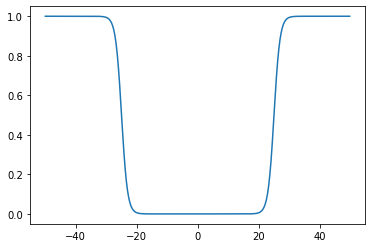

In [6]:
# Now on to the potential term
w2free = lambda k, m2: np.sqrt((k*dk)**2. + m2)
w2bare = np.genfromtxt('../data/frequencies'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'.txt')[1:]
confOmega = lambda x, lamb, fraction: (1./(1. + np.exp(2.*lamb * (x + hLat/fraction))) if x < 0 else 1./(1. + np.exp(-2.*lamb * (x - hLat/fraction))))

Ux = lambda xL, m2, lamb, fraction: np.asarray([m2*confOmega(x, lamb, fraction) for x in xL])
Uk = lambda k, m2, lamb, fraction: np.size(xlist)**-1. * np.sum(Ux(xlist, m2, lamb, fraction)*np.exp(-1j*xlist*k*dx*dk))
if True:
    plt.plot(xlist*dx, Ux(xlist, m2test, lamb, fraction))
    plt.show()

# Below is the field power spectrum and expected mass correction
mat = np.loadtxt('../data/transfMatrix'+'_N'+str(nLat)+'_L'+str(int(lenLat))+'.txt', skiprows=2)
transfMatrix = np.reshape(mat[:,0]+1j*mat[:,1],(knyq,nLat))
if False:
    for n in range(knyq):
        plt.plot(xlist*dx, transfMatrix[n])
        plt.plot(xlist*dx, np.dot(np.transpose(transfMatrix), np.asarray([0. if x!=n else 1. for x in range(knyq)])), ls=':')
        #plt.xlim(xlist[0]*dx, 0.)
        plt.show()

# Overall field normalization
norm = 1./ phi0 / np.sqrt(4. * lenLat)
# Free field (constant mass term) field modes \phi_k
free_eigenbasis = np.asarray([norm / w2free(k, m2test)**0.25 for k in klist])
free_eigenbasis[klist==0]=0.
free_eigenbasis = np.roll(free_eigenbasis, hLat)

# Conformal mass term field modes \phi_k in the field eigenbasis
eigenbasis = norm / w2bare**0.25
eigenbasis[0]=0.
# Coordinate transformation of field modes \phi_k into momentum basis
spectral_field = np.dot(np.transpose(transfMatrix), eigenbasis)
spectral_field[0]=0.

#Plot field modes \phi_k for both dispersion relations and compare
if False:
    plt.plot(klist*dk, spectral_field, 'o', ms=2)
    plt.plot(klist*dk, free_eigenbasis, 'o', ms=2)
    plt.show()

#Compute full field \phi(x) as the inverse FT of the \phi_k's
free_field_fluctuations = np.asarray([np.sum(free_eigenbasis*np.exp(-1j*x*klist*dx*dk)) for x in xlist])
field_fluctuations = np.asarray([np.sum(spectral_field*np.exp(-1j*x*klist*dx*dk)) for x in xlist])

#Plot fields \phi(x) for both dispersion relations and compare
if False:
    plt.plot(xlist*dx, free_field_fluctuations)
    plt.plot(xlist*dx, field_fluctuations)
    plt.show()

#Power spectrum of field in the BH background
pspec = np.abs(spectral_field)**2
fluct_variance = np.sum(pspec)

th_masses = lambda m2, lamb: m2 + 0.5 * lamb * fluct_variance
omega2_fit = lambda k, m2: k**2. + m2

In [7]:
all_data = np.asarray([extract_sim(nTime, nLat, sim) for sim in range(nSims)])
print('Done')
print(np.shape(all_data))

Done
(1, 2, 512, 512)


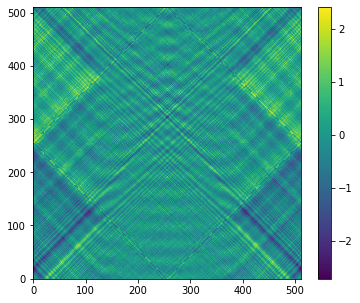

In [8]:
list_lambda = [lamb]
sim = 0
fig, ax = plt.subplots(figsize = (6, 5), ncols=1)
im0 = ax.imshow(all_data[sim][0], aspect='auto', interpolation='none', origin='lower')
clb = plt.colorbar(im0, ax = ax)
plt.show()

In [9]:
intervals = np.asarray([2.*np.pi/dt/np.sqrt(i) for i in w2bare])
list_intervals = lambda i: np.asarray([y for y in [int(np.round(x*2.*np.pi/(dt*np.sqrt(w2bare[i])))) for x in range(1, nTime, 1)] if y < nTime])

[-6.938893903907228e-18, -0.023918410904663616, -0.07019935283660753, -0.13976754010065823, -0.32783201957375985, -0.21455517275120914, -0.16155768482821004, -0.07858999491791752, -0.04655659323920179, 0.05892041850675941, 0.06862072723418625, 0.14642027852419323, 0.24749851754240026, 0.24405406336292357, 0.12754568340578903, 0.13404756680952581, 0.07942722077269654, -0.029948412171782582]


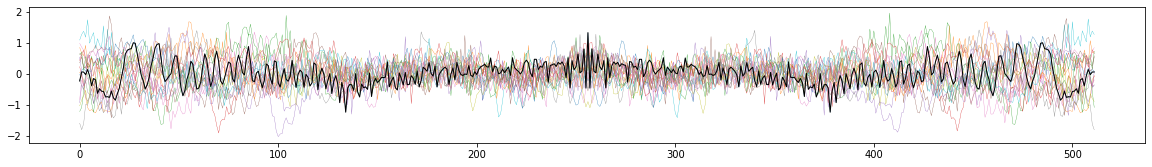

In [10]:
if True:
    print([np.mean(all_data[:, 0, time]) for time in range(0,nTime,30)])

    for sim in range(0, nSims):
#        fig, ax = plt.subplots(2, 1, figsize = (20, 5))
        fig, ax = plt.subplots(figsize = (20, 2.5), nrows=1)
        [ax.plot(all_data[sim, 0, time], linewidth=0.3) for time in range(0,nTime,30)]
        ax.plot(all_data[sim, 0, 0], linewidth=1, color='k')
#        [ax[1].plot(all_data[sim, 1, time]) for time in range(0,nTime,30)]
        plt.show()

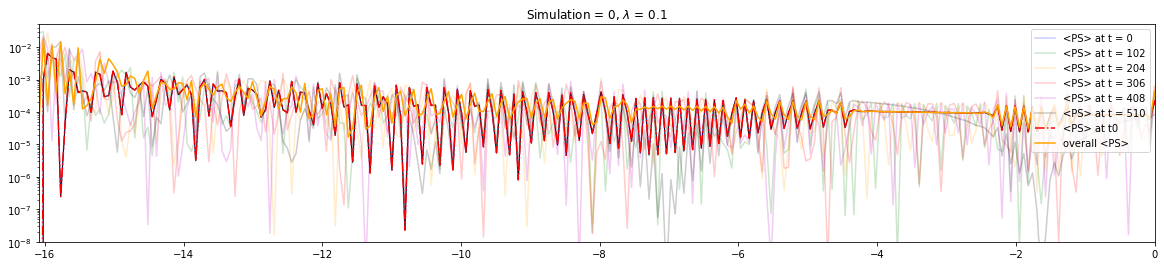

In [11]:
fig, ax = plt.subplots(1, 1, figsize = (20,4))
colors = cycle(('b', 'g', 'orange', 'r', 'm', 'k'))

th_field_PS = np.abs(spectral_field)**2.
plt.plot(klist*dk, th_field_PS, linewidth=1, color='k')

for time in np.arange(0, nTime, 102):
    col=next(colors)
    averagePS_slice = np.mean(np.abs(np.fft.ifft(all_data[:,0,time]))**2., axis=0)
    plt.plot(klist*dk, averagePS_slice, color=col, label='<PS> at t = '+str(time), alpha=0.2, ls='-')

averagePS_initialization = np.mean(np.abs(np.fft.ifft(all_data[:,0,0]))**2., axis=0)
plt.plot(klist*dk, averagePS_initialization, color='red', label='<PS> at t0', alpha=1, ls='-.')

averagePS_fullpropagation = np.mean(np.abs(np.fft.ifft(all_data[:,0], axis=1))**2., axis=(0,2))
plt.plot(klist*dk, averagePS_fullpropagation, color='orange', label='overall <PS>', alpha=1, ls='-')

plt.legend(loc='upper right')
plt.title(r'Simulation = '+str(sim)+r', $\lambda$ = '+str(lamb))
plt.axhline(0, ls='--', color='darkgray')
plt.xlim(klist[0]*dk, 0.005)
plt.ylim(1e-8,0.05)
plt.yscale('log')
plt.show()